In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

### Import Latent Space Embeddings

In [10]:
# load in embedding dataframe
df = pd.read_csv('../data/encoded_data.csv', index_col=0)

In [40]:
# split into training & validation sets

train_len = int(0.8 * df.shape[0])
#test_len = df.shape[0] - train_len

train_indices = np.random.choice(df.shape[0], size=train_len, replace=False)
train_dataset = df.iloc[train_indices,:]
test_dataset = df.drop(index=df.iloc[train_indices, :].index.tolist())

In [52]:
# normalize the data
scaler = preprocessing.StandardScaler().fit(train_dataset)

train_scaled = scaler.transform(train_dataset)

### Generating Clusters

In [53]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(train_scaled)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x7f1c504b49d0>)

In [56]:
df_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_results["mean_test_score"] = -df_results["mean_test_score"]
df_results = df_results.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_results.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
21,4,full,-44669.579318
22,5,full,-43733.301322
20,3,full,-43702.402254
23,6,full,-42368.400609
19,2,full,-39034.323910


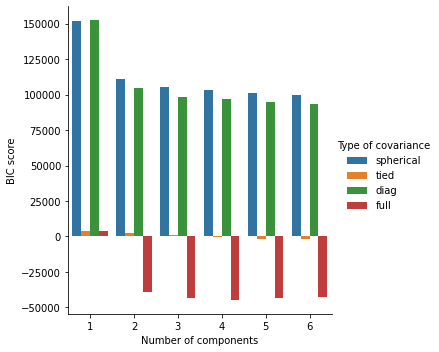

In [57]:
sns.catplot(
    data=df_results,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

### Visualizing Clusters & Determining Performance

In [58]:
grid_search.best_estimator_.means_

array([[ 2.07100617e-01,  1.08383300e+00, -4.19197977e-01,
         8.79503336e-01,  5.45588426e-01, -3.69462682e-01,
        -4.90530010e-01,  2.45171608e-02, -6.51994743e-01,
        -6.84539017e-01,  1.94255231e-01,  8.98251496e-01,
         8.00817525e-01,  8.46693104e-01, -8.52964861e-01,
        -1.06570654e-01,  1.12635614e+00, -4.10732672e-01,
         1.78442097e-01,  1.22257018e-02,  7.94086429e-01,
         2.82126952e-01,  1.84742081e-01, -4.38629738e-01,
        -1.41966675e+00,  1.10521654e-01, -4.79258064e-02,
        -5.51636686e-01,  5.53965212e-01, -5.83733984e-01,
        -4.95334462e-01, -5.23299925e-01],
       [ 4.75203988e-02, -1.49747596e+00, -6.95749425e-01,
         3.42645954e-01, -2.38656828e-01, -7.18041190e-02,
        -6.02818633e-01,  1.03657065e+00, -1.36061923e-01,
        -2.02297950e-01,  1.67072609e-02, -1.65808120e+00,
         5.92974754e-01, -8.42755828e-02, -2.60871700e-01,
        -5.48913971e-01, -1.02265483e+00,  7.30979417e-01,
        -4.56